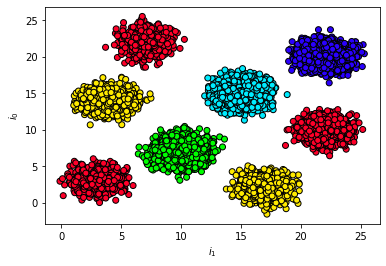

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from src.common.train_data import normal2DCluster

cov = np.diag((1,1))

classes = [(0, (3,3), cov, 1000),
           (1, (14,4), cov, 1500),
           (2, (7,10), cov, 3000),
           (3, (15,15), cov, 3000),
           (1, (2,17),cov, 1500),
           (0, (10,22), cov, 1000),
           (0, (22,7), cov, 1000),
           (4, (20,22), cov, 3000)]
n_classes = 5
train_data, train_labels = normal2DCluster(classes)

train_min_y = train_data[:,0].min()
train_max_y = train_data[:,0].max()
train_min_x = train_data[:,1].min()
train_max_x = train_data[:,1].max()

cmap = plt.get_cmap('gist_rainbow')
def colorizeLabel(l):
  return cmap(l/n_classes)

_, ax = plt.subplots()
ax.scatter(train_data[:,1], train_data[:,0], c=colorizeLabel(train_labels), edgecolor='black')
_ = ax.set_ylabel("$i_0$")
_ = ax.set_xlabel("$i_1$")

Epochs: 61epoch [01:22,  1.35s/epoch, loss=9.27]


Displaying: render/mlp_classifier_1654305072.481596.mp4


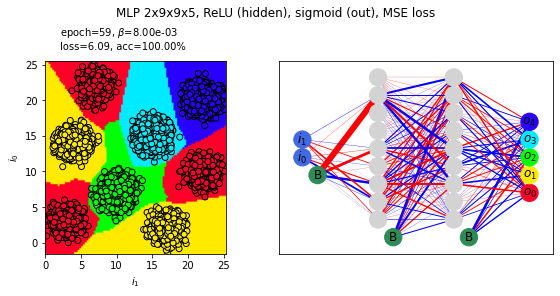

In [17]:
from src.neuronal_network.mlp import MLP
from src.neuronal_network.loss import MSE
from src.neuronal_network.activation import Sigmoid, ReLU, SoftMax
from src.common.plot import sample2DClassifier, plotMultiWeightLayer
from src.common.vectorize import one_hot
from matplotlib.animation import FuncAnimation
from datetime import datetime
from IPython.display import Video
import tqdm

batch_size = 5
epochs = 60
learning_rate = 0.008
duration_ms = max(epochs*200, 3000)

mlp = MLP(2, [9,9], n_classes, hidden_act=ReLU, output_act=Sigmoid)
loss = MSE()

fig, ax = plt.subplots(1,2)
fig.patch.set_color('white')
fig.suptitle(str(mlp) + f", {loss} loss")
fig.set_figwidth(fig.get_figwidth()*(1+(len(mlp.weightsList())/10)))
fig.set_constrained_layout(True)
ax[0].scatter(train_data[:,1], train_data[:,0], c=colorizeLabel(train_labels), edgecolor='black')
_ = ax[0].set_ylabel("$i_0$")
_ = ax[0].set_xlabel("$i_1$")
txt_epoch = ax[0].text(2,train_max_y-train_min_y, "")
img_classifier = ax[0].imshow([[1]])


epoch_bar = tqdm.tqdm(desc="Epochs", total=epochs, unit="epoch")

def doEpoch(epoch):
  perm = np.random.permutation(train_data.shape[0])

  batches_data = np.split(train_data[perm], train_data.shape[0]/batch_size)
  batches_labels = np.split(one_hot(train_labels[perm], n_classes), train_labels.shape[0]/batch_size)

  sample2DClassifier(img_classifier, mlp.classify, colorizeLabel,
                     cmap, train_min_y, train_max_y, train_min_x, train_max_x)
  ax[1].clear()
  plotMultiWeightLayer(ax[1], mlp.weightsList(), 50, 5, colorizeLabel)
  

  total_loss = 0
  for b_data, b_labels in zip(batches_data, batches_labels):
    prediction = mlp.forward(b_data)
    total_loss += loss(prediction, b_labels).sum()
    mlp.backward(loss.gradient())
    mlp.fit(learning_rate)

  acc = sum(mlp.classify(train_data) == train_labels) / len(train_labels)
  txt_epoch.set_text(f"epoch={epoch}, $\\beta$={learning_rate:.02e}\nloss={total_loss:.02f}, acc={acc*100:.02f}%")
  epoch_bar.update(1)
  epoch_bar.set_postfix_str(f"loss={total_loss:.02f}")

anim = FuncAnimation(fig, doEpoch, interval=duration_ms/epochs, frames=epochs)
fname = f"render/mlp_classifier_{datetime.timestamp(datetime.now())}.mp4"
anim.save(fname, dpi=120)
print(f"Displaying: {fname}")
Video(url=fname)